# Flappy Bird - Deep Q-Network

In this notebook, we will implement a **Deep Q-Network (DQN)** for the Flappy Bird game.

The **Deep Q-Network (DQN) algorithm** is a variant of the Q-Learning that uses a neural network to approximate the Q-function. In 2013, DeepMind proposed this algorithm as a way to solve Atari games with a high level of efficiency.

Two different memory approaches are used:

- **Experience Replay (ER)**: The most common approach, where the most recent experiences are stored in a replay memory.
- **Prioritized Experience Replay (PER)**: The approach where experiences are stored in a replay memory and the importance of each experience is stored in a priority queue.

## Index

- [1. Initial Setup](#1.-Initial-Setup)
- [2. Check the Gym environment](#2-check-the-gym-environment)
- [3. Define custom functions](#3-define-custom-functions)
- [4. Training the RL agent](#4-training-the-rl-agent)
  - [4.1 Agent (Replay Memory) - Training](#4-1-agent-replay-memory-training)
  - [4.1 Agent (Replay Memory) - Scores](#4-1-agent-replay-memory-scores)
  - [4.1 Agent (Replay Memory) - Losses](#4-1-agent-replay-memory-losses)
  - [4.2 Agent (Prioritized Memory) - Training](#4-2-agent-prioritized-memory-training)
  - [4.2 Agent (Prioritized Memory) - Scores](#4-2-agent-prioritized-memory-scores)
  - [4.2 Agent (Prioritized Memory) - Losses](#4-2-agent-prioritized-memory-losses)
- [5. Save network weights](#5-save-network-weights)
- [6. Load network weights](#6-load-network-weights)
- [7. Test the agent](#7-test-the-agent)
- [8. Conclusions](#8-conclusions)

## References

- [[1312.5602] Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
- [[2007.06700] Revisiting Fundamentals of Experience Replay](https://arxiv.org/abs/2007.06700)
- [[1511.05952] Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

## 1. Initial Setup

Add project root directory to the path.

In [16]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent))

Imports modules

In [17]:
import cv2
import numpy as np
import flappy_bird_gym
import matplotlib.pyplot as plt

from src.trainer import Trainer
from src.utils import play_env
from src.dqn.agent import Agent
from src.dqn.config import AgentConfig

seed = 1993

## 2. Check the Gym environment

Before we start, we need to check how the environment works. For this, we will check the action space and observation space.

In [18]:
env = flappy_bird_gym.make("FlappyBird-v0")

env.seed(seed)

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print(f"Number of actions: {action_size}")
print(f"Sample state shape: {env.observation_space.shape}")
print(f"Sample state: {env.reset()}")

Number of actions: 2
Sample state shape: (2,)
Sample state: [ 1.65625    -0.20117188]


## 3. Define custom functions

In the next cell, we define a `custom_prep_state()` function that will be used to preprocess the state of the game.

We will replace the `prep_state()` function of the agent with this one.

In [19]:
def reshape_image(image: np.ndarray, shape: tuple):
    """
    Reshape an image to a given shape.

    Args:
    - image: Image to reshape.
    - shape: Shape to reshape the image to. e.g. (84, 84)

    Returns:
    - Reshaped image.
    """
    return cv2.resize(image, shape)
    
def custom_prep_state(state: np.ndarray) -> np.ndarray:
    # Reshape the image to 84x84
    #state = reshape_image(state, (84, 84))

    # Convert the image to grayscale
    #state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)

    #state = state.ravel()
    return state

sample_state = custom_prep_state(env.reset())
print(f"Shape of state: {sample_state.shape}")
sample_state

Shape of state: (2,)


array([ 1.65625   , -0.10351562])

## 4. Training the RL agent

Firstly, we will instantiate the AgentConfig that defines the hyperparameters of our DQN Agent.

In [20]:
params = AgentConfig(
    state_size=len(sample_state),
    action_size=action_size,
    seed=seed,
    prioritized_memory=False,
    model_dir="../models/DQN.pt"
)

params.dict()

{'state_size': 2,
 'action_size': 2,
 'seed': 1993,
 'nb_hidden': (64, 64),
 'learning_rate': 0.0005,
 'memory_size': 100000,
 'prioritized_memory': False,
 'batch_size': 64,
 'gamma': 0.99,
 'tau': 0.001,
 'small_eps': 0.03,
 'update_every': 4,
 'epsilon_start': 1.0,
 'epsilon_end': 0.01,
 'epsilon_decay': 0.99995,
 'model_dir': '../models/DQN.pt'}

### 4.1 Agent (Replay Memory) - Training

In [21]:
%%time

agent = Agent(**params.dict())

# Add our custom prep_state function to the agent
agent.prep_state = custom_prep_state

trainer = Trainer(agent, env, n_episodes=3000, early_stop=130, verbose=True)
trainer.run(logs_callback=agent.logs)

Episode 100	Avg Score: 101.00	Epsilon: 0.60	Avg. MSE Loss: 0.00
Episode 200	Avg Score: 101.00	Epsilon: 0.36	Avg. MSE Loss: 0.00
Episode 300	Avg Score: 101.00	Epsilon: 0.22	Avg. MSE Loss: 0.00
Episode 400	Avg Score: 100.50	Epsilon: 0.13	Avg. MSE Loss: 0.00
Episode 500	Avg Score: 94.85	Epsilon: 0.08	Avg. MSE Loss: 0.00
Episode 600	Avg Score: 95.00	Epsilon: 0.05	Avg. MSE Loss: 0.00
Episode 700	Avg Score: 100.22	Epsilon: 0.03	Avg. MSE Loss: 0.00
Episode 800	Avg Score: 99.76	Epsilon: 0.02	Avg. MSE Loss: 0.00
Episode 900	Avg Score: 100.31	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1000	Avg Score: 101.13	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1100	Avg Score: 101.00	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1200	Avg Score: 101.00	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1300	Avg Score: 101.07	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1400	Avg Score: 101.00	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1500	Avg Score: 101.00	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 1600	Avg Score: 101.00	Epsilo

True

### 4.2 Agent (Replay Memory) - Scores

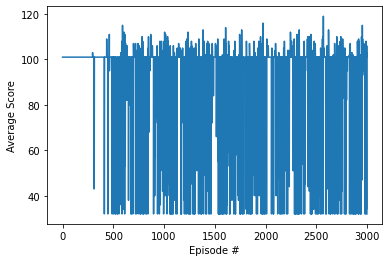

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainer.scores)), trainer.scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

### 4.3 Agent (Replay Memory) - Losses

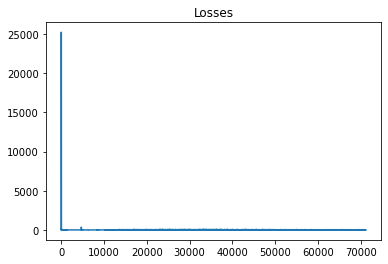

In [8]:
plt.plot(agent.losses)
plt.title("Losses")
plt.show()

### 4.2 Agent (Prioritized Memory) - Training

In [ ]:
%%time

params.prioritized_memory = True

agent = Agent(**params.dict())

# Add our custom prep_state function to the agent
agent.prep_state = custom_prep_state

trainer = Trainer(agent, env, n_episodes=1000, early_stop=200, verbose=True)
trainer.run(logs_callback=agent.logs)

print(f"Episode: {trainer.last_episode} - Score: {trainer.best_score}")

### 4.2 Agent (Prioritized Memory) - Scores

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainer.scores)), trainer.scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

### 4.2 Agent (Prioritized Memory) - Losses

In [ ]:
plt.plot(agent.losses)
plt.title("Losses")
plt.show()

## 5. Save network weights

In [9]:
agent.save_model(params.model_dir)

## 6. Load network weights

In [10]:
del agent

agent = Agent(**params.dict())
agent.prep_state = custom_prep_state

agent.load_model(params.model_dir)

## 7. Test the agent

In [15]:
env = flappy_bird_gym.make("FlappyBird-rgb-v0")
env.seed(seed)

play_env(agent, env, fps=30, render=True)

Score: 101.00


## 8. Conclusions

Pending